Usando o exemplo 499

In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [3]:
df = pd.read_csv('../news_clean_onlly.csv')

In [4]:
df.head()

,Unnamed: 0,title,subject,date,Label,clean_text,label_number,char_count,word_count,avg_word_length
0,0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",Fake,donald trump just couldn t wish all americans ...,0,2620,474,5.527426
1,1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",Fake,house intelligence committee chairman devin nu...,0,1850,304,6.085526
2,2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",Fake,on friday it was revealed that former milwauke...,0,3298,564,5.847518
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017",Fake,on christmas day donald trump announced that h...,0,2462,423,5.820331
4,4,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017",Fake,pope francis used his annual christmas day mes...,0,2292,420,5.457143


In [5]:
df.shape

(38516, 10)

<Axes: xlabel='Label', ylabel='count'>

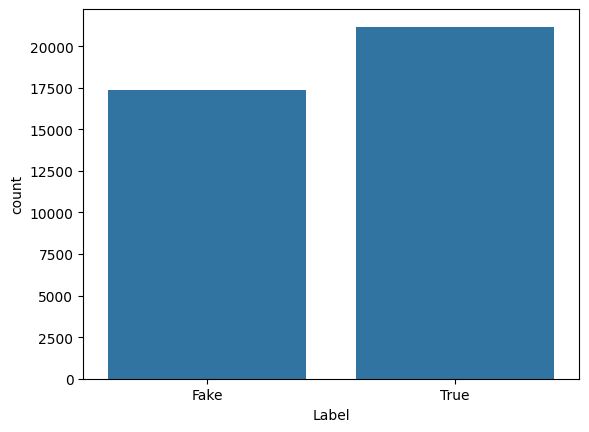

In [6]:
sns.countplot(x='Label', data=df)

**Pré-Processamento**

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [9]:
df["clean_text"] = df["title"].apply(preprocess_text)

In [10]:
df.head(5)

,Unnamed: 0,title,subject,date,Label,clean_text,label_number,char_count,word_count,avg_word_length
0,0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",Fake,donald trump sends embarrassing new year eve m...,0,2620,474,5.527426
1,1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",Fake,drunk bragging trump staffer started russian c...,0,1850,304,6.085526
2,2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",Fake,sheriff david clarke becomes internet joke thr...,0,3298,564,5.847518
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017",Fake,trump obsessed even obamas name coded website ...,0,2462,423,5.820331
4,4,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017",Fake,pope francis called donald trump christmas speech,0,2292,420,5.457143


<Axes: xlabel='Label', ylabel='count'>

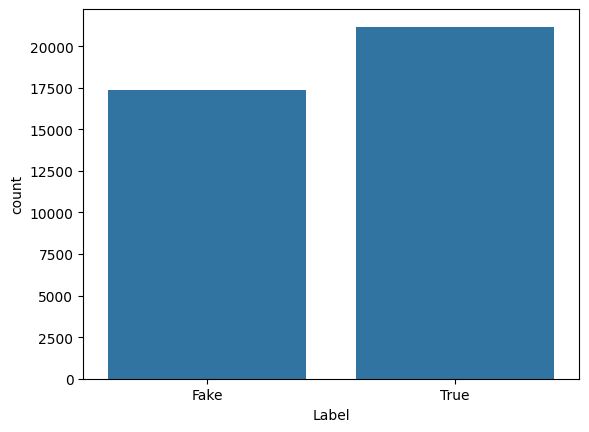

In [11]:
sns.countplot(x="Label", data=df) # validando se mudou as classes

In [12]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['Label'])

In [13]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [14]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [16]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [18]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


867/867 ━━━━━━━━━━━━━━━━━━━━ 535s 562ms/step - accuracy: 0.8912 - loss: 0.2464 - val_accuracy: 0.9497 - val_loss: 0.1371
Epoch 2/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 493s 550ms/step - accuracy: 0.9555 - loss: 0.1219 - val_accuracy: 0.9536 - val_loss: 0.1178
Epoch 3/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 466s 537ms/step - accuracy: 0.9669 - loss: 0.0923 - val_accuracy: 0.9481 - val_loss: 0.1334
Epoch 4/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 452s 477ms/step - accuracy: 0.9752 - loss: 0.0706 - val_accuracy: 0.9455 - val_loss: 0.1283
Epoch 5/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 498s 541ms/step - accuracy: 0.9806 - loss: 0.0567 - val_accuracy: 0.9448 - val_loss: 0.1533
Epoch 6/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 478s 510ms/step - accuracy: 0.9845 - loss: 0.0456 - val_accuracy: 0.9455 - val_loss: 0.1430
Epoch 7/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 391s 450ms/step - accuracy: 0.9893 - loss: 0.0346 - val_accuracy: 0.9387 - val_loss: 0.1897
Epoch 8/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 321s 309ms/step - accuracy: 0.9917 - loss: 0.02

**OVERSAMPLING**

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)  # Define um estado aleatório para reprodutibilidade
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_pad, y_train)

In [20]:
# treino do modelo com os dados desbalanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 397s 414ms/step - accuracy: 0.9899 - loss: 0.0371 - val_accuracy: 0.9909 - val_loss: 0.0330
Epoch 2/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 332s 348ms/step - accuracy: 0.9947 - loss: 0.0190 - val_accuracy: 0.9918 - val_loss: 0.0300
Epoch 3/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 390s 356ms/step - accuracy: 0.9971 - loss: 0.0117 - val_accuracy: 0.9903 - val_loss: 0.0379
Epoch 4/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 399s 372ms/step - accuracy: 0.9967 - loss: 0.0126 - val_accuracy: 0.9903 - val_loss: 0.0320
Epoch 5/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 331s 318ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9953 - val_loss: 0.0254
Epoch 6/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 358s 354ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9947 - val_loss: 0.0252
Epoch 7/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 371s 341ms/step - accuracy: 0.9983 - loss: 0.0059 - val_accuracy: 0.9953 - val_loss: 0.0254
Epoch 8/10
955/955 ━━━━━━━━━━━━━━━━━━━━ 300s 314ms/step - accuracy: 0.9986 -

<Axes: xlabel='label_encoded', ylabel='count'>

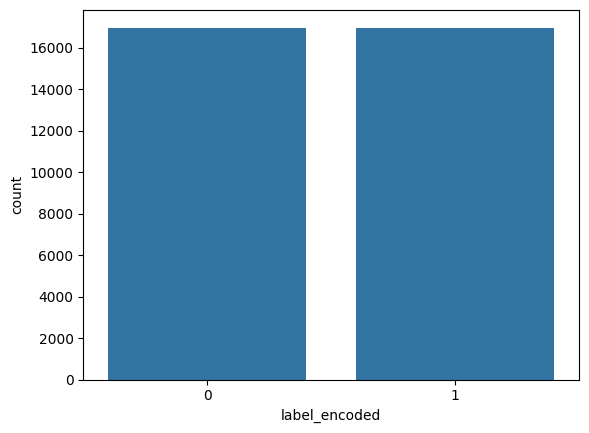

In [21]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [22]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


241/241 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      3504
           1       0.93      0.95      0.94      4200

    accuracy                           0.93      7704
   macro avg       0.93      0.93      0.93      7704
weighted avg       0.93      0.93      0.93      7704



In [23]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.9329
Precisão: 0.9329
Recall: 0.9329
F1-Score: 0.9328


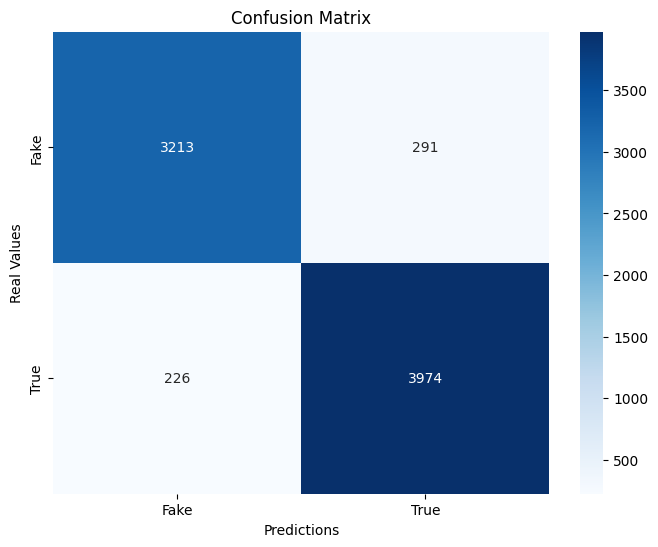

In [24]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [26]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Número da linha no X_test: 499
Original text:
party motherland north korea kim herald missile test setback
Classe real: True
Classe predita: True
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step
[(np.str_('korea'), 0.001575729581001964), (np.str_('party'), 0.0014466510637941735), (np.str_('setback'), 0.0009285968005788961), (np.str_('herald'), -0.0009050609084525669), (np.str_('north'), 0.000795059981254152), (np.str_('missile'), 0.0005744532848652781), (np.str_('test'), 0.000555756170791979), (np.str_('kim'), -0.0004455592069363778), (np.str_('motherland'), -0.00017073037060707686)]


In [27]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
korea: 0.0016
party: 0.0014
setback: 0.0009
herald: -0.0009
north: 0.0008
missile: 0.0006
test: 0.0006
kim: -0.0004
motherland: -0.0002


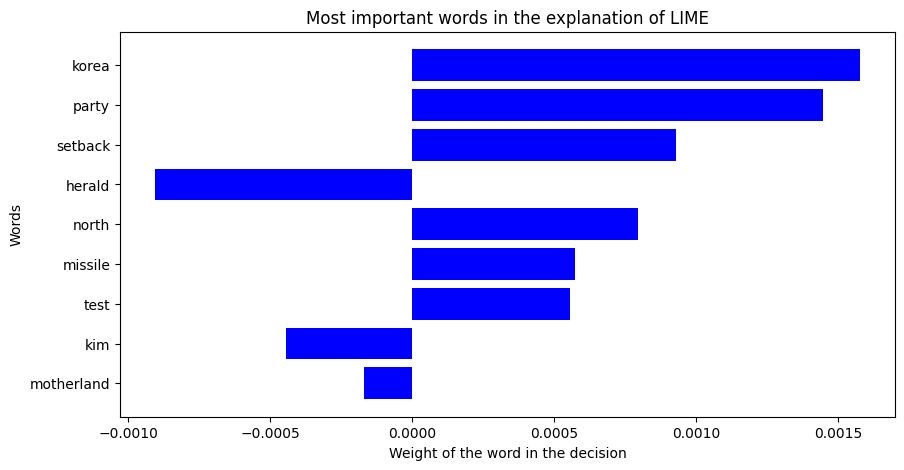

In [28]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [29]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

korea: 0.001575729581001964
party: 0.0014466510637941735
setback: 0.0009285968005788961
herald: -0.0009050609084525669
north: 0.000795059981254152
missile: 0.0005744532848652781
test: 0.000555756170791979
kim: -0.0004455592069363778
motherland: -0.00017073037060707686


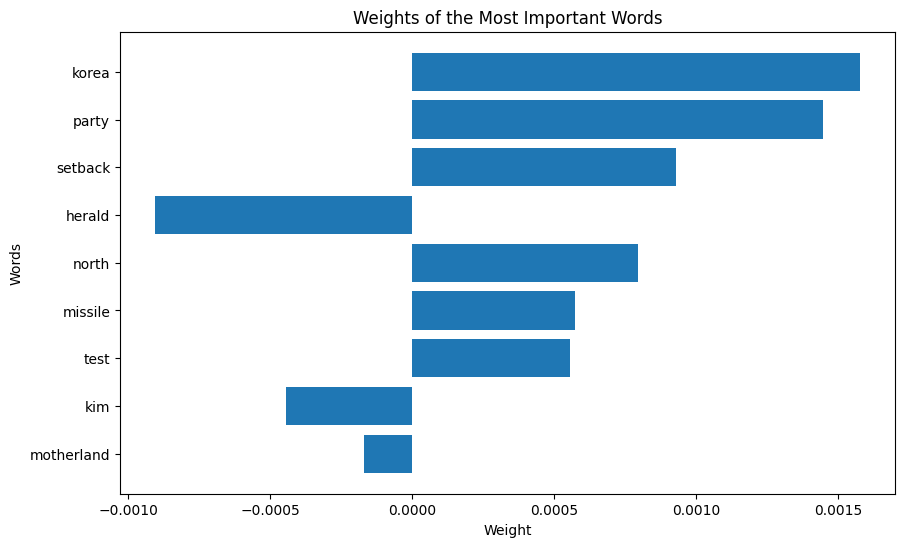

In [30]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [31]:
le.classes_

array(['Fake', 'True'], dtype=object)

Palavras do exemplo e seus pesos de atenção na decisão do LSTM:
   Feature    Weight
7     test  0.999983
8  setback  0.518868
6  missile  0.343012
5    <OOV>  0.150533
4      kim  0.035349
0    party  0.022205
3    korea  0.010710
1    <OOV>  0.004667
2    north  0.000000


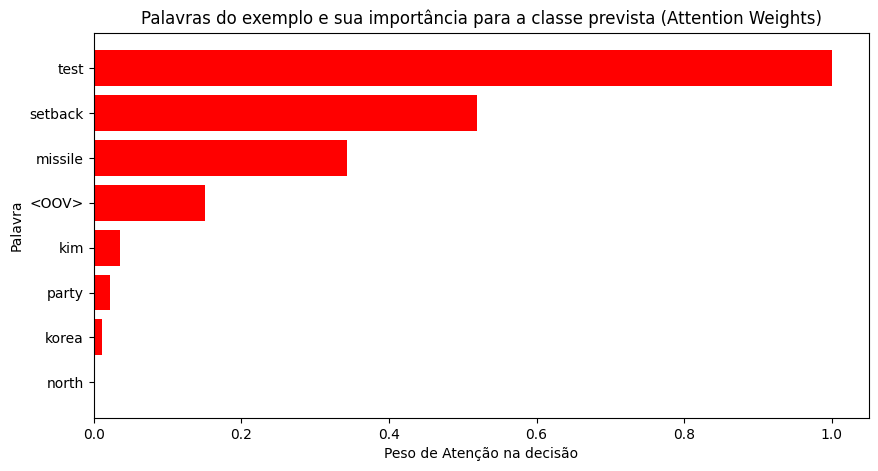

In [32]:
from tensorflow.keras.models import Model
import tensorflow as tf

# ========= 1. "Feature names" → tokens do texto (equivalente ao CountVectorizer) =========
seq = tokenizer.texts_to_sequences([sample_text])
seq_pad = pad_sequences(seq, maxlen=max_len, padding="post")

# Tokens reais do exemplo (equivalente a vect.build_analyzer())
tokens = tokenizer.sequences_to_texts(seq)[0].split()

# ========= 2. "Coeficientes" → extrair pesos de atenção =========
# Usar Model API para criar modelos intermediários
try:
    # Tentar com inputs[0]
    lstm_model = Model(
        inputs=model.inputs[0],
        outputs=model.layers[1].output  # LSTM output
    )
    lstm_output = lstm_model.predict(seq_pad, verbose=0)
except:
    # Fallback: fazer previsão direta e extrair via função customizada
    # Criar uma função que retorna a saída do LSTM
    lstm_layer = model.layers[1]
    
    # Usar a previsão normal e extrair via submodelo
    def get_lstm_output(x):
        embedding = model.layers[0](x)
        lstm_out = model.layers[1](embedding)
        return lstm_out
    
    lstm_output = get_lstm_output(seq_pad).numpy()

# Extrair pesos da camada de atenção
attention_layer = model.layers[2]  # AttentionLayer está no índice 2

# Obter os pesos treinados
W = attention_layer.W.numpy()
b = attention_layer.b.numpy()

# Calcular pesos de atenção manualmente usando a fórmula da camada AttentionLayer
# et = tanh(x @ W + b), at = softmax(et)
et = np.squeeze(np.tanh(np.dot(lstm_output[0], W) + b), axis=-1)
at = np.exp(et - np.max(et)) / np.sum(np.exp(et - np.max(et)), axis=0)  # softmax

# Remover padding: pegar apenas os pesos das sequências reais
num_real_tokens = len(tokens)
pesos_atencao = at[-num_real_tokens:].flatten()[:num_real_tokens]

# Normalizar os pesos para comparabilidade com SVM
pesos_atencao = (pesos_atencao - pesos_atencao.min()) / (pesos_atencao.max() - pesos_atencao.min() + 1e-8)

# ========= 3. Criar DataFrame (equivalente ao SVM) =========
importancias = pd.DataFrame({
    "Feature": tokens,
    "Weight": pesos_atencao
})

# ========= 4. Marcar palavras do exemplo (todas são do exemplo no LSTM) =========
importancias["No_Exemplo"] = True

# ========= 5. Ordenar por importância =========
importancias_exemplo = importancias.sort_values(
    by="Weight",
    ascending=False
)

print("Palavras do exemplo e seus pesos de atenção na decisão do LSTM:")
print(importancias_exemplo[["Feature", "Weight"]])

# ========= 6. Plotar (mesmo estilo do SVM) =========
plt.figure(figsize=(10, 5))
plt.barh(
    importancias_exemplo["Feature"],
    importancias_exemplo["Weight"],
    color="red"
)
plt.xlabel("Peso de Atenção na decisão")
plt.ylabel("Palavra")
plt.title("Palavras do exemplo e sua importância para a classe prevista (Attention Weights)")
plt.gca().invert_yaxis()
plt.show()
